# LIME Implementation from scratch

https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions

https://nbviewer.org/url/arteagac.github.io/blog/lime_image.ipynb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
gray_cmap=LinearSegmentedColormap.from_list('gy',[(.3,.3,.3),(.8,.8,.8)], N=2) 
np.random.seed(222) #Seed for random numbers generation

def set_plot_style(title='Original Data'):
    plt.figure(figsize=(12, 8))    
    plt.axis([-2,2,-2,2])
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)

In [ ]:
df = pd.read_csv("https://arteagac.github.io/blog/lime/artificial_data.csv",header = 'infer')
df.head()

In [ ]:
X = df[['x1','x2']].values
y = df['y'].values
X = (X - np.mean(X,axis=0)) / np.std(X,axis=0) #Standarization of data

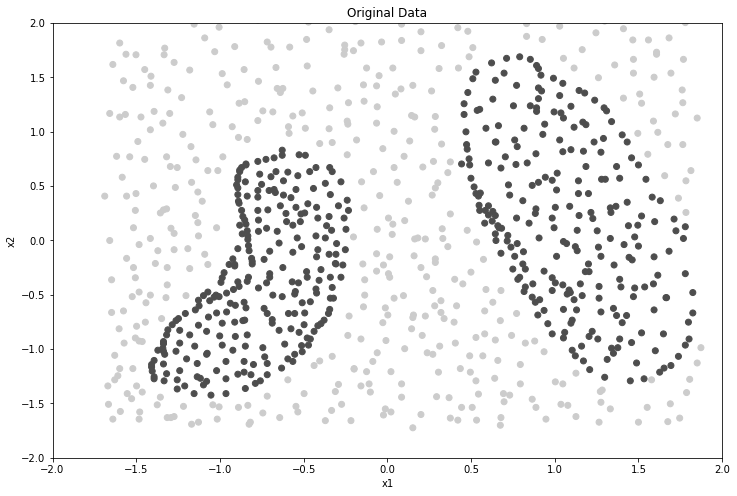

In [ ]:
set_plot_style()
plt.scatter(X[:,0],X[:,1], c=y, cmap=gray_cmap)

In [ ]:
# Start by training any model on the data
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X, y) 

RandomForestClassifier()

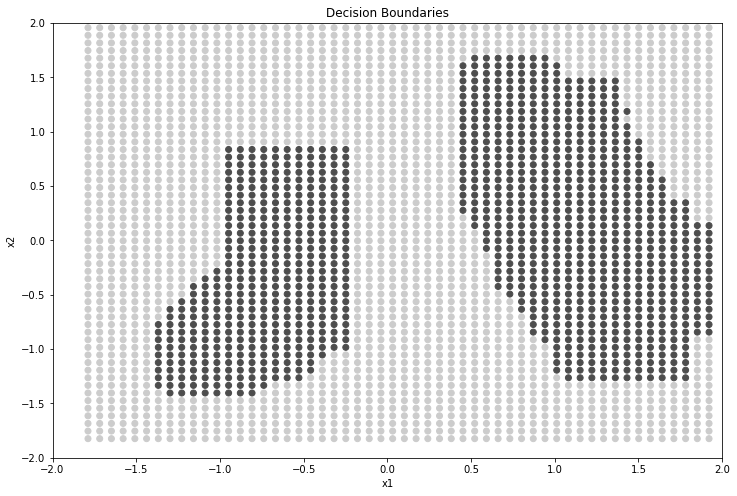

In [ ]:
# Perform a mesh-grid to visualize the boundaries used by the model to generate the specific predictions

#Function to create a mesh grid
def make_meshgrid(x1, x2, h=.02,x1_min=0,x1_max=0,x2_min=0,x2_max=0):
    if x1_min==0 and x1_max==0 and x2_min==0 and x2_max==0:
        x1_min, x1_max = x1.min() - 0.1, x1.max() + 0.1
        x2_min, x2_max = x2.min() - 0.1, x2.max() + 0.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    return np.vstack((xx1.ravel(), xx2.ravel())).T

#Create mesh grid and predict class for each element in mesh grid
XX = make_meshgrid(X[:,0],X[:,1],h=.07)
yy = classifier.predict(XX)

set_plot_style(title='Decision Boundaries')
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)

LIME generates local explanations, in other words, explanations for individual instances in a dataset. 

1. Generate a new dataset of perturbations around the instance to be explained. 
2. The trained machine learning classifier is used to predict the class of each instance in the new generated dataset. 
3. A simpler model with i(e.g. linear regression model), is fitted and used to explain the prediction of the classifier. 
4. Before fitting a simpler model, the instances in the new generated dataset are weighed based on their distance to the original instance being explained. 

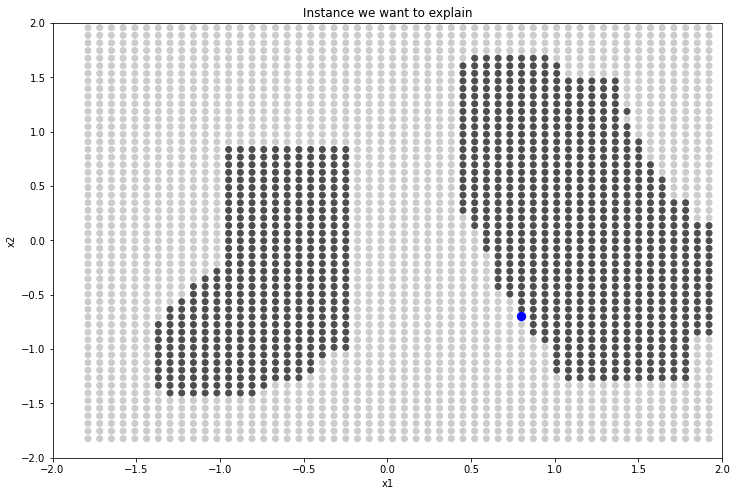

In [ ]:
# Variable to explain
Xi = np.array([0.8,-0.7]) 
set_plot_style(title='Instance we want to explain')
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

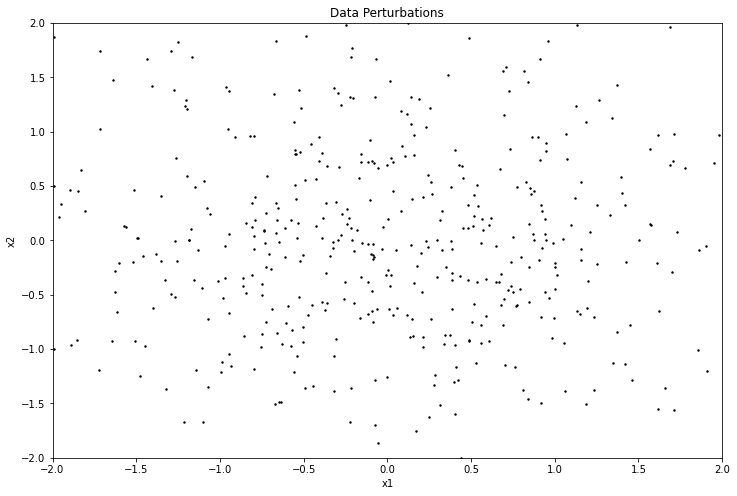

In [ ]:
# 1. Generate the perturbations. Given the simplicity of the data we can use a gaussian distributed perturbation
num_perturb = 500
X_lime = np.random.normal(0,1,size=(num_perturb,X.shape[1]))

set_plot_style(title='Data Perturbations')
plt.scatter(X_lime[:,0],X_lime[:,1],s=2,c="black")

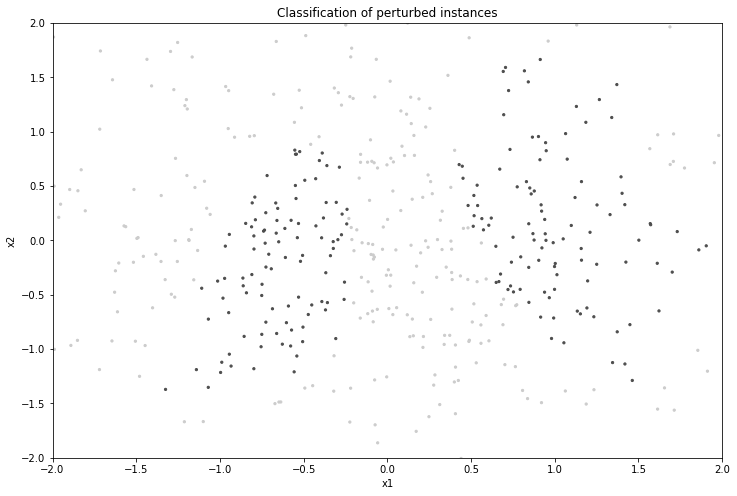

In [ ]:
# 2. Given the new perturbed dataset we apply the already trained model to predict the new class
y_lime = classifier.predict(X_lime)
set_plot_style(title='Classification of perturbed instances')
plt.scatter(X_lime[:,0],X_lime[:,1],s=5, c=y_lime, cmap=gray_cmap)

In [ ]:
# And specifically our point of interest
classifier.predict(np.array([0.8,-0.7]).reshape(1, -1) )

array([1], dtype=int64)

In [ ]:
# 3. Compute the distances and weights. In this case we decide to use:
#   - Euclidean distance
#   - Kernel weights to decide which instances are more or less relevant

kernel_width = 0.2  # Kernel Weights
distances = np.sum((Xi - X_lime)**2,axis=1) #Euclidean distance
weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2))) #Kernel function

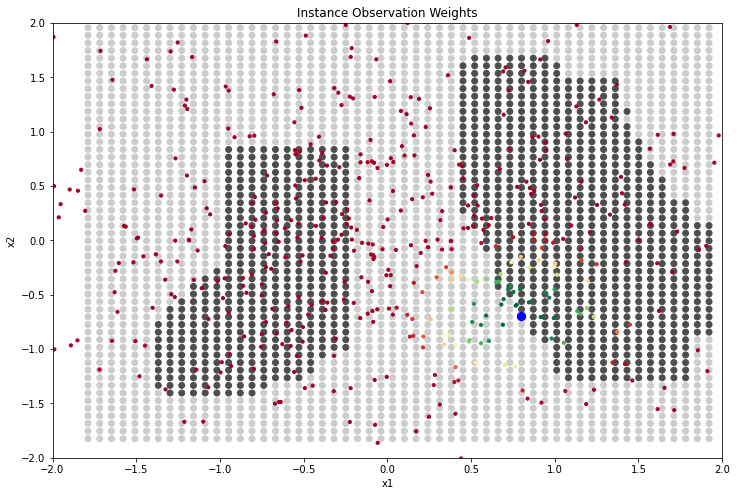

In [ ]:
set_plot_style(title='Instance Observation Weights')
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap) 
plt.scatter(X_lime[:,0],X_lime[:,1],s=10,c= weights,cmap="RdYlGn") 
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

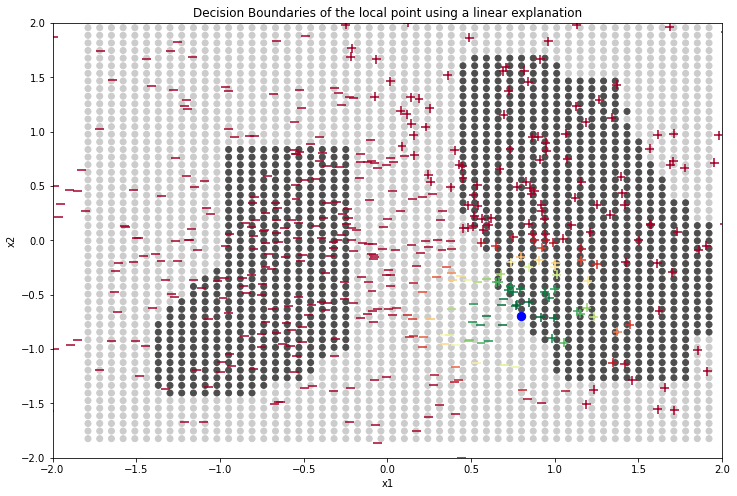

In [ ]:
# 4. In this case we fit a linear regression model on X_lime (the perturbed data points) and y_lime (the predictions based on the model we want to explain)

from sklearn.linear_model import LinearRegression
simpler_model = LinearRegression() 
simpler_model.fit(X_lime, y_lime, sample_weight=weights)
y_linmodel = simpler_model.predict(X_lime)
y_linmodel = y_linmodel < 0.5 #Conver to binary class

set_plot_style(title='Decision Boundaries of the local point using a linear explanation')
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap) 
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70)
plt.scatter(X_lime[y_linmodel==0,0],X_lime[y_linmodel==0,1],c= weights[y_linmodel==0],cmap="RdYlGn",marker="_",s=80)
plt.scatter(X_lime[y_linmodel==1,0],X_lime[y_linmodel==1,1],c= weights[y_linmodel==1],cmap="RdYlGn",marker="+",s=80)